# 地震警报级别预测：随机森林方法

这是一个使用`scikit-learn`的`RandomForestClassifier`来预测地震警报级别的Jupyter Notebook。

**分析流程:**
1.  **数据加载与探索**: 加载训练和测试数据集，进行初步的数据分析。
2.  **探索性数据分析 (EDA)**: 通过可视化手段深入了解特征分布和特征与标签之间的关系。
3.  **异常值处理**: 使用Z-score方法识别并移除异常值。
4.  **特征工程与预处理**: 创建新的交互特征和多项式特征，并对特定特征进行标准化。
5.  **处理类别不平衡**: 应用SMOTE技术来平衡训练数据中的类别分布。
6.  **模型训练与调优**: 使用10折交叉验证和网格搜索来寻找随机森林模型的最佳超参数。
7.  **最终模型训练**: 使用找到的最佳参数在全部训练数据上训练最终模型。
8.  **生成提交文件**: 使用最终模型对测试集进行预测并生成提交文件。

### 1. 导入所需库

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import itertools
import warnings

warnings.filterwarnings('ignore')

### 2. 数据加载与预处理

In [25]:
# Data Acquisition
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("✅ Data Loaded Successfully!")
print(df.head(), "\n")
print(df.info(), "\n")
print(df_test.head(), "\n")
print(df_test.info(), "\n")

✅ Data Loaded Successfully!
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
1   2        7.0    579    3    3  -13      0
2   3        6.6    624    0    2  -98      0
3   4        6.8    630    1    3  -57      0
4   5        6.7     20    7    6   29      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         909 non-null    int64  
 1   magnitude  909 non-null    float64
 2   depth      909 non-null    int64  
 3   cdi        909 non-null    int64  
 4   mmi        909 non-null    int64  
 5   sig        909 non-null    int64  
 6   label      909 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 49.8 KB
None 

       id  magnitude  depth  cdi  mmi  sig
0  100001        7.0     14    8    7    0
1  100002        7.3     37    5    5   65
2  100003        7.0    660    4    3  -13


In [3]:
# === 新增单元格：检查重复数据 ===
print("🔎 正在检查训练数据中的重复行（忽略 'id' 列）...")

# 定义需要检查重复的列
columns_to_check = df.columns.drop('id')

# 找出所有重复的行（包括第一次出现的）
duplicate_rows = df[df.duplicated(subset=columns_to_check, keep=False)]

if not duplicate_rows.empty:
    print(f"🚨 发现 {len(duplicate_rows)} 行重复数据（显示所有重复的实例）:")
    # 按特征排序，方便比对
    display(duplicate_rows.sort_values(by=list(columns_to_check)))
else:
    print("✅ 在训练数据中未发现重复行。")

🔎 正在检查训练数据中的重复行（忽略 'id' 列）...
🚨 发现 50 行重复数据（显示所有重复的实例）:


,id,magnitude,depth,cdi,mmi,sig,label
158,159,6.50,10,6,7,-112,1
852,853,6.50,10,6,7,-112,1
250,251,6.50,20,0,6,-118,0
269,270,6.50,20,0,6,-118,0
800,801,6.53,12,8,8,-36,1
846,847,6.53,12,8,8,-36,1
600,601,6.60,9,8,8,26,3
684,685,6.60,9,8,8,26,3
509,510,6.60,10,8,8,28,3
544,545,6.60,10,8,8,28,3


### 3. 探索性数据分析 (EDA)

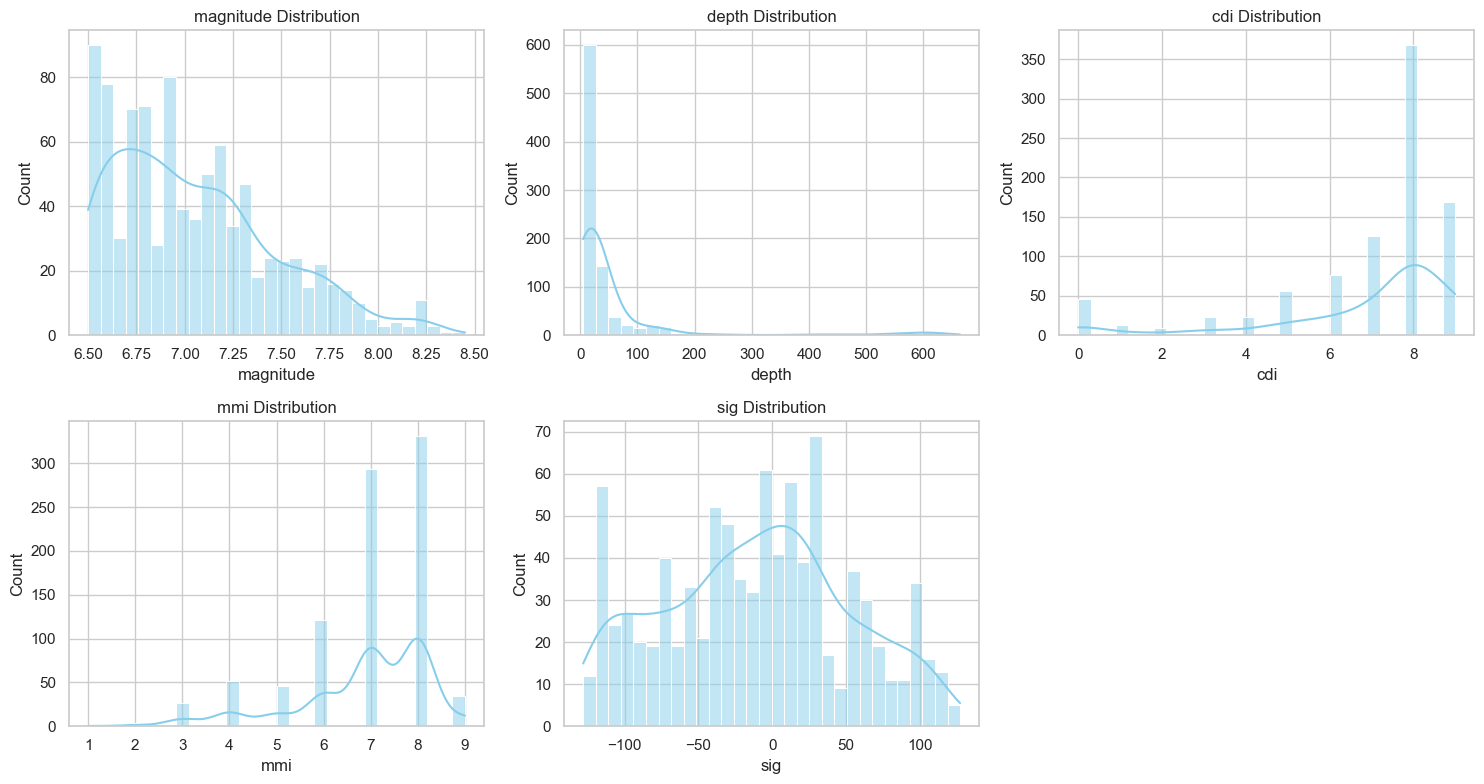

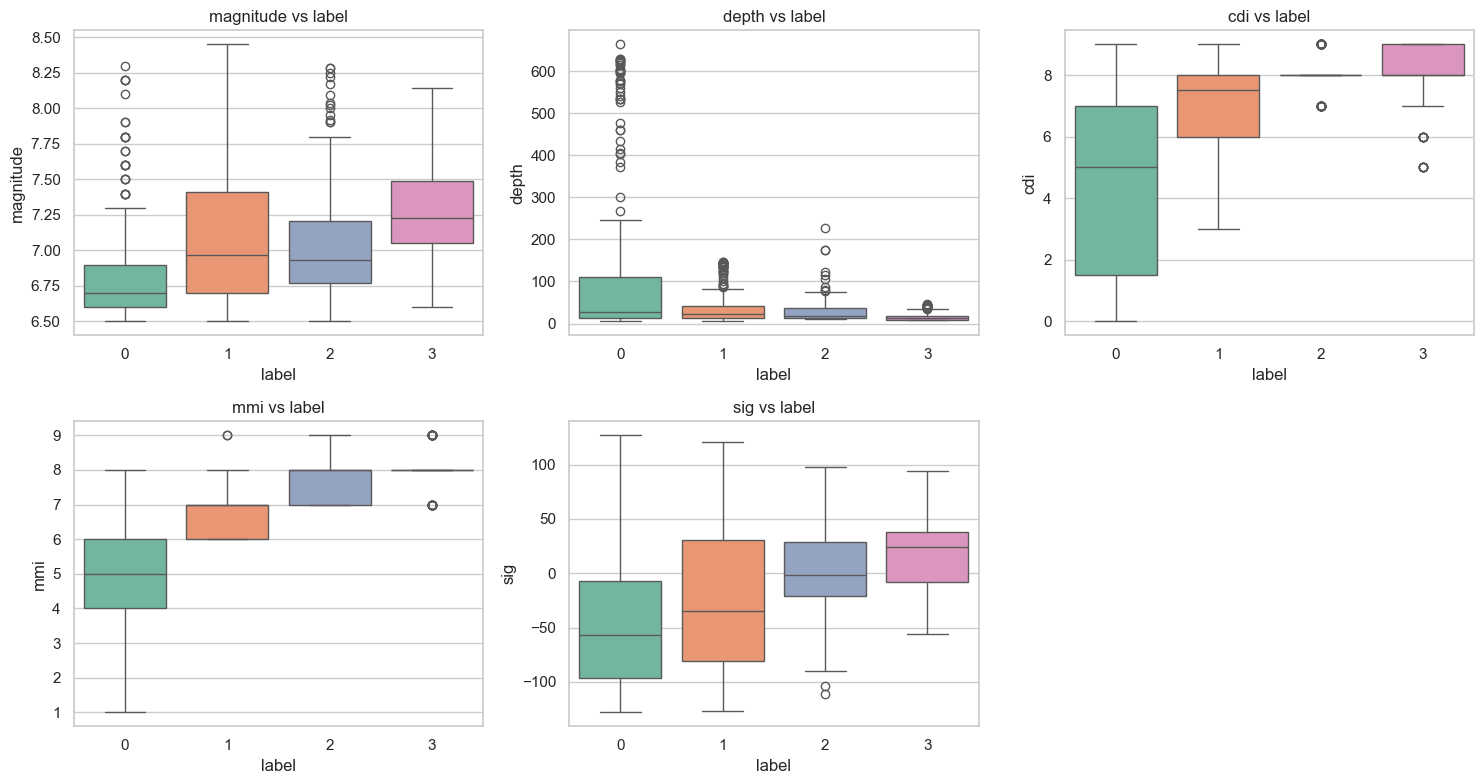

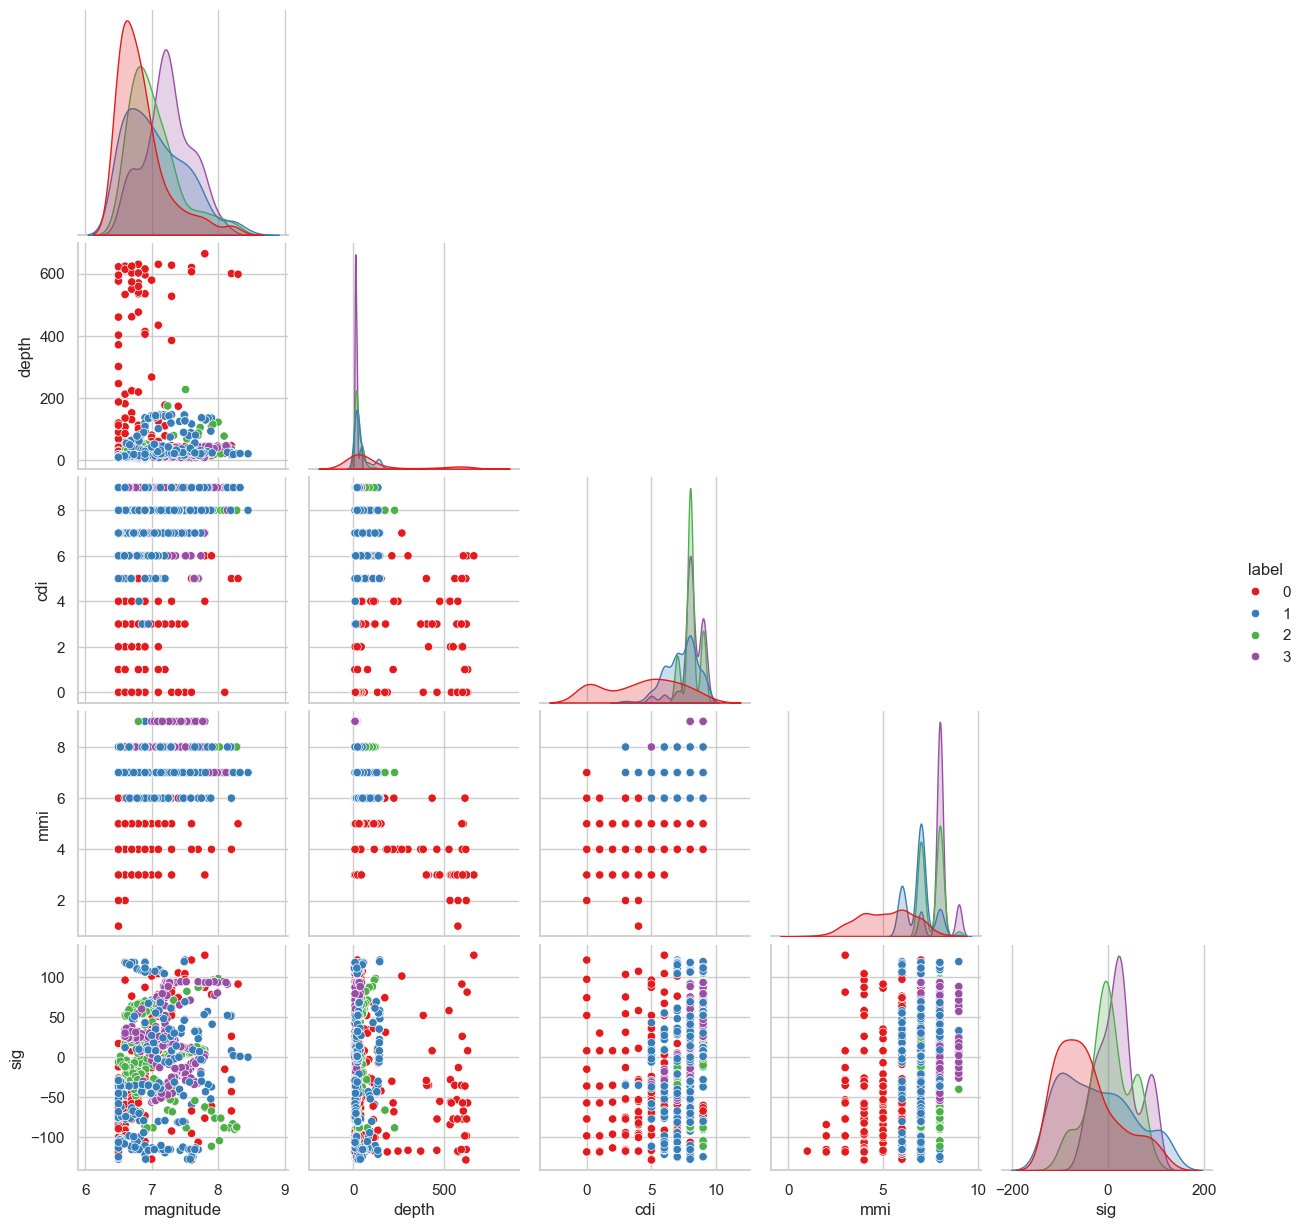

In [4]:
# Set style
sns.set_theme(style="whitegrid")

# Define features to analyze
features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

# 1️⃣ 每列特征的直方图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 2️⃣ 每列特征与 label 的箱型图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=col, data=df, hue='label', palette='Set2', legend=False)
    plt.title(f'{col} vs label')
plt.tight_layout()
plt.show()

# 3️⃣ 特征与 label 的散点图矩阵（pairplot）
sns.pairplot(df, vars=features, hue='label', palette='Set1', corner=True)
plt.show()

### 4. 数据清洗与特征工程

In [29]:
from scipy.stats import zscore

# 定义特征列
feature_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

print("🔬 Applying Z-score to handle outliers with a threshold of 3...")

# 计算所有特征的Z-score
z_scores = df_cleaned[feature_cols].apply(zscore)

# 创建一个布尔掩码，当所有特征的Z-score绝对值都小于等于3时为True
no_outliers = (np.abs(z_scores) <= 3).all(axis=1)

# 应用掩码，保留非异常值行
df_cleaned = df_cleaned[no_outliers]

removed_count = initial_rows - len(df_cleaned)

print(f"✅ Outlier handling complete using Z-score.")
print(f"\n原始样本数: {initial_rows}, 清洗后样本数: {len(df_cleaned)}")
print(f"移除了 {removed_count} 个异常样本。")


# 查看处理后数据基本情况
print("\n✅ 数据预览：")
print(df_cleaned.head())

🔬 Applying Z-score to handle outliers with a threshold of 3...
✅ Outlier handling complete using Z-score.

原始样本数: 909, 清洗后样本数: 871
移除了 38 个异常样本。

✅ 数据预览：
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
4   5        6.7     20    7    6   29      0
5   6        7.6     26    9    8    7      1
6   7        6.9     10    9    9  119      1
7   8        6.5     10    7    7  -12      0


In [30]:
# Step 1: 对 depth 先对数压缩
df_cleaned['depth'] = np.log1p(df_cleaned['depth'])

# Step 2: 标准化所有数值特征
scaler = StandardScaler()
numerical_features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

# Feature Engineering
print("\n🔬 Performing Feature Engineering...")

df_cleaned['cdi_mmi_interaction'] = df_cleaned['cdi'] * df_cleaned['mmi']

df_cleaned['cdi_sq'] = df_cleaned['cdi']**2
df_cleaned['mmi_sq'] = df_cleaned['mmi']**2

print("✅ New features created: 'cdi_mmi_interaction', 'cdi_sq', 'mmi_sq'")
print(df_cleaned.head())


# 删除无关列
X = df_cleaned.drop(columns=["id", "label"]).values

# same feature engineering for test set
df_test_processed = df_test.copy()
df_test_processed['depth'] = np.log1p(df_test_processed['depth'])
df_test_processed[numerical_features] = scaler.transform(df_test_processed[numerical_features])
df_test_processed['cdi_mmi_interaction'] = df_test_processed['cdi'] * df_test_processed['mmi']
df_test_processed['cdi_sq'] = df_test_processed['cdi']**2
df_test_processed['mmi_sq'] = df_test_processed['mmi']**2
X_submission = df_test_processed.drop(columns=["id"]).values


y = df_cleaned["label"].values

print("\n✅ Data prepared for 10-fold Cross-Validation.")


🔬 Performing Feature Engineering...
✅ New features created: 'cdi_mmi_interaction', 'cdi_sq', 'mmi_sq'
   id  magnitude     depth       cdi       mmi       sig  label  \
0   1  -0.363447  0.173302 -1.427941 -2.528013 -0.373585      0   
4   5  -0.845056 -0.101017 -0.034659 -0.863061  0.617344      0   
5   6   1.322187  0.221776  0.894196  0.801891  0.265724      1   
6   7  -0.363447 -0.931556  0.894196  1.634368  2.055788      1   
7   8  -1.326666 -0.931556 -0.034659 -0.030585 -0.037947      0   

   cdi_mmi_interaction    cdi_sq    mmi_sq  
0             3.609854  2.039016  6.390850  
4             0.029913  0.001201  0.744874  
5             0.717048  0.799587  0.643030  
6             1.461445  0.799587  2.671157  
7             0.001060  0.001201  0.000935  

✅ Data prepared for 10-fold Cross-Validation.


### 5. 模型训练：随机森林

Original dataset shape Counter({np.int64(1): 230, np.int64(3): 229, np.int64(2): 213, np.int64(0): 199})
Resampled dataset shape Counter({np.int64(0): 230, np.int64(1): 230, np.int64(2): 230, np.int64(3): 230})


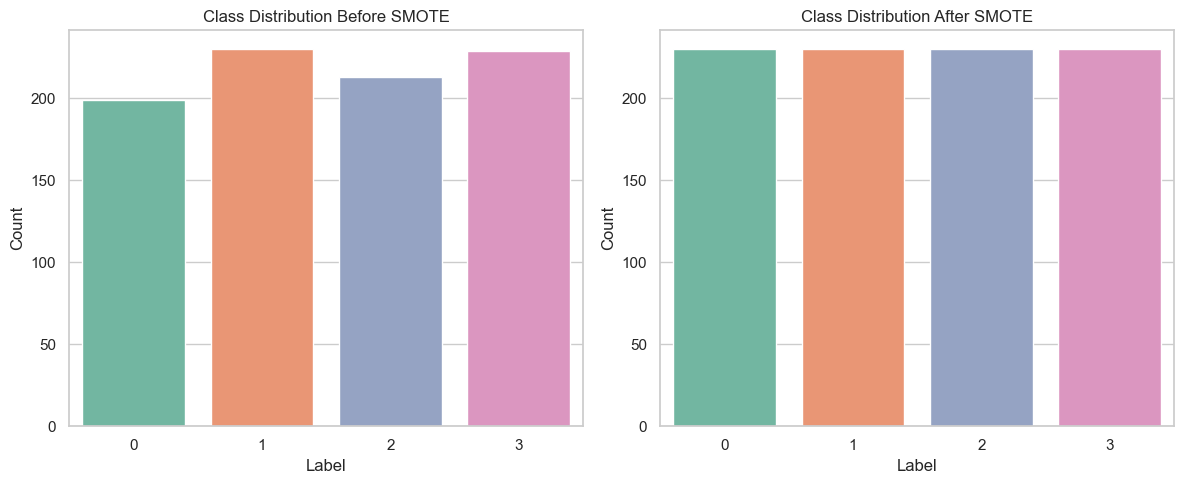

In [22]:
import collections
from imblearn.over_sampling import SMOTE

# Show class distribution on the full dataset before SMOTE
print("Original dataset shape %s" % collections.Counter(y))

sm = SMOTE(random_state=5434)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Resampled dataset shape %s" % collections.Counter(y_resampled))

# Visualize the class distribution before and after SMOTE
plt.figure(figsize=(12, 5))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='Set2')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette='Set2')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

### 5a. 自定义随机森林实现
在进行模型训练之前，我们先定义自己实现的决策树和随机森林分类器。

In [8]:
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed

class MyDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def _gini(self, y):
        if y.size == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / y.size
        return 1 - np.sum(probabilities**2)

    def _best_split(self, X, y, feature_indices):
        best_gini = 1
        best_idx, best_thr = None, None
        
        for idx in feature_indices:
            thresholds = np.unique(X[:, idx])
            for thr in thresholds:
                # split dataset
                y_left = y[X[:, idx] < thr]
                y_right = y[X[:, idx] >= thr]
                
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                # calculate weighted gini impurity
                gini = (len(y_left) / len(y)) * self._gini(y_left) + \
                       (len(y_right) / len(y)) * self._gini(y_right)
                
                if gini < best_gini:
                    best_gini = gini
                    best_idx, best_thr = idx, thr
                    
        return best_idx, best_thr

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth) or \
           len(np.unique(y)) == 1 or \
           num_samples < self.min_samples_split:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'leaf_value': leaf_value}

        if self.max_features:
            if self.max_features == 'sqrt':
                num_selected_features = int(np.sqrt(num_features))
            elif self.max_features == 'log2':
                num_selected_features = int(np.log2(num_features)) if num_features > 1 else 1
            else:
                num_selected_features = self.max_features
            
            feature_indices = np.random.choice(num_features, num_selected_features, replace=False)
        else:
            feature_indices = np.arange(num_features)

        best_idx, best_thr = self._best_split(X, y, feature_indices)
        
        if best_idx is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'leaf_value': leaf_value}

        left_indices = X[:, best_idx] < best_thr
        right_indices = X[:, best_idx] >= best_thr
        
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {'feature_index': best_idx, 
                'threshold': best_thr, 
                'left': left_tree, 
                'right': right_tree}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _predict_one(self, x, node):
        if 'leaf_value' in node:
            return node['leaf_value']
        
        if x[node['feature_index']] < node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self._predict_one(x, self.tree) for x in X])

class MyRandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=10, min_samples_split=2, max_features='sqrt', n_jobs=-1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.trees = []

    def _train_tree(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        
        tree = MyDecisionTree(max_depth=self.max_depth, 
                              min_samples_split=self.min_samples_split,
                              max_features=self.max_features)
        tree.fit(X_sample, y_sample)
        return tree

    def fit(self, X, y):
        """训练随机森林"""
        self.trees = []
        if self.n_jobs == -1 or self.n_jobs > 1:
            with ThreadPoolExecutor(max_workers=self.n_jobs if self.n_jobs > 1 else None) as executor:
                futures = [executor.submit(self._train_tree, X, y) for _ in range(self.n_estimators)]
                for future in as_completed(futures):
                    self.trees.append(future.result())
        else:
            for _ in range(self.n_estimators):
                self.trees.append(self._train_tree(X, y))

    def predict(self, X):
        """进行预测"""
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        
        y_pred = [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(y_pred)

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'max_depth': self.max_depth,
                'min_samples_split': self.min_samples_split,
                'max_features': self.max_features}

print("✅ Custom Decision Tree and Random Forest classifiers defined.")

✅ Custom Decision Tree and Random Forest classifiers defined.


In [35]:
print("🚀 Starting Grid Search for MyRandomForest with SMOTE and 10-Fold CV...")

param_grid = {
    'n_estimators': [50],       # 减少数量以便快速演示，原1500
    'max_depth': [20],       # 减少深度选项
    'min_samples_split': [2],
    'max_features': ['log2'] # 自定义实现支持 'sqrt' 和 'log2'
}
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_score = -1
best_params = None

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5434)
sm = SMOTE(random_state=5434)

for i, params in enumerate(param_combinations):
    print(f"--- Testing Combination {i+1}/{len(param_combinations)} ---")
    print(params)
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # print(f"  -- Fold {fold+1}/10 --") # Can be verbose
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]
        
        # Apply SMOTE only to the training data of this fold
        X_train_resampled, y_train_resampled = sm.fit_resample(X_train_fold, y_train_fold)
        
        # 使用自定义的随机森林
        rf = MyRandomForestClassifier(n_jobs=-1, **params)
        # rf.fit(X_train_fold, y_train_fold)
        rf.fit(X_train_resampled, y_train_resampled)
        y_pred_val = rf.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred_val, average="macro")
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    print(f"Average Macro-F1 Score for this combination: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"🎉 New Best Score! 🎉")

print("================================================")
print(f"✅ Grid Search Complete!")
print(f"🏆 Best CV Macro-F1 Score: {best_score:.4f}")
print(f"🔧 Best Hyperparameters: {best_params}")
print("================================================")

# ===================================================================
# Final Model Training with Best Parameters
# ===================================================================
print("🚀 Training Final MyRandomForest Model with Best Hyperparameters on Full Data...")

# Apply SMOTE to the entire dataset for final training
X_resampled_full, y_resampled_full = sm.fit_resample(X, y)

# 使用自定义的随机森林进行最终训练
final_rf = MyRandomForestClassifier(n_jobs=-1, **best_params)
final_rf.fit(X_resampled_full, y_resampled_full)

print("✅ Final model trained.")

🚀 Starting Grid Search for MyRandomForest with SMOTE and 10-Fold CV...
--- Testing Combination 1/1 ---
{'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'log2'}
Average Macro-F1 Score for this combination: 0.8634
🎉 New Best Score! 🎉
✅ Grid Search Complete!
🏆 Best CV Macro-F1 Score: 0.8634
🔧 Best Hyperparameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 2, 'max_features': 'log2'}
🚀 Training Final MyRandomForest Model with Best Hyperparameters on Full Data...
✅ Final model trained.



🔎 Generating Out-of-Fold Confusion Matrix...
--- Processing Fold 1/10 for OOF predictions ---
--- Processing Fold 2/10 for OOF predictions ---
--- Processing Fold 3/10 for OOF predictions ---
--- Processing Fold 4/10 for OOF predictions ---
--- Processing Fold 5/10 for OOF predictions ---
--- Processing Fold 6/10 for OOF predictions ---
--- Processing Fold 7/10 for OOF predictions ---
--- Processing Fold 8/10 for OOF predictions ---
--- Processing Fold 9/10 for OOF predictions ---
--- Processing Fold 10/10 for OOF predictions ---

✅ OOF predictions generated.

Out-of-Fold Confusion Matrix:
[[161  30   8   0]
 [ 14 194  15   7]
 [  0   8 190  15]
 [  0   4  10 215]]

Out-of-Fold Classification Report:
              precision    recall  f1-score   support

           0     0.9200    0.8090    0.8610       199
           1     0.8220    0.8435    0.8326       230
           2     0.8520    0.8920    0.8716       213
           3     0.9072    0.9389    0.9227       229

    accuracy     

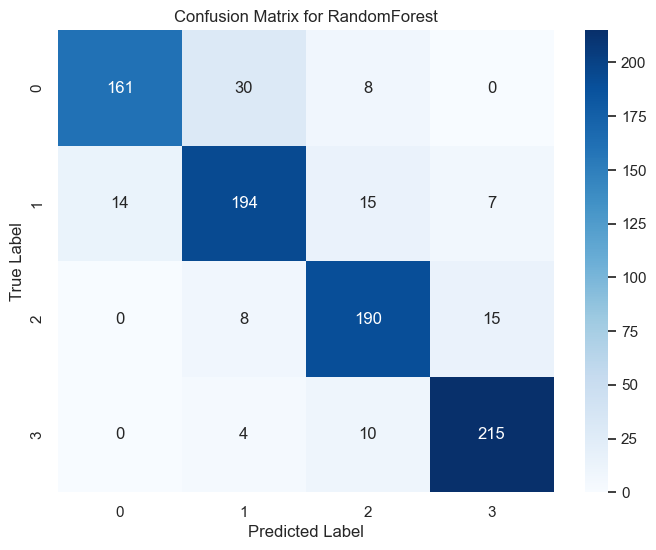

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

print("\n🔎 Generating Out-of-Fold Confusion Matrix...")


oof_preds = np.zeros(len(y))
# oof_probas = np.zeros((len(y), len(np.unique(y)))) 自定义实现暂不支持 predict_proba

skf_oof = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sm_oof = SMOTE(random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf_oof.split(X, y)):
    print(f"--- Processing Fold {fold+1}/10 for OOF predictions ---")
    X_train_fold, y_train_fold = X[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X[val_idx], y[val_idx]
    
    # Apply SMOTE only to the training data of this fold
    X_train_resampled, y_train_resampled = sm_oof.fit_resample(X_train_fold, y_train_fold)
    

    model = MyRandomForestClassifier(n_jobs=-1, **best_params)
    model.fit(X_train_resampled, y_train_resampled)
    

    oof_preds[val_idx] = model.predict(X_val_fold)

print("\n✅ OOF predictions generated.")

# 计算并打印混淆矩阵
cm = confusion_matrix(y, oof_preds)
print("\nOut-of-Fold Confusion Matrix:")
print(cm)

# 打印分类报告
print("\nOut-of-Fold Classification Report:")
print(classification_report(y, oof_preds, digits=4))

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for RandomForest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 6. 生成提交文件

In [ ]:
# ===================================================================
# Generate Submission with MyRandomForest
# ===================================================================

# 1️⃣ Use the preprocessed test data from the feature engineering step
# X_submission is already prepared and scaled
print("\n🚀 Generating predictions for submission...")

# 2️⃣ Use the FINAL trained MyRandomForest model to predict
y_pred_submission_rf = final_rf.predict(X_submission)

# 3️⃣ Save the prediction results
submission_rf = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_submission_rf
})
submission_rf.to_csv("submission_my_rf.csv", index=False)

print("✅ MyRandomForest predictions complete. Results saved to submission_my_rf.csv")
print(submission_rf.head())


🚀 Generating predictions for submission...
✅ RandomForest predictions complete. Results saved to submission_rf.csv
       id  label
0  100001      2
1  100002      0
2  100003      0
3  100004      1
4  100005      0
